# Large-Scale and Online Kernel Methods

Course: Machine Learning II, Data Science Master (Universidad de Cantabria - UIMP).  
Lecturer: Steven Van Vaerenbergh.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

# inline plots
%matplotlib inline

Before we start, let us recall the following formulae:

1. Kernel expansion: $$f(x) = \sum_{i=1}^n \alpha_i \kappa(x, x_i)$$
2. Kernel ridge regression $$\boldsymbol{\alpha} = \left( {\bf K} + \lambda {\bf I}  \right)^{-1}{\bf y}$$


# Part 1. Large-scale kernel methods

## 1.1 Nyström approximation

The Nyström method approximates a kernel map using a subset of the training data.

$${\bf K} = \begin{bmatrix} {\bf K}_{11} & {\bf K}_{12}\\ {\bf K}_{21} & {\bf K}_{22} \end{bmatrix}$$

$${\bf C} = \begin{bmatrix} {\bf K}_{11}\\ {\bf K}_{21}\end{bmatrix}$$

$${\bf \tilde{K}} = {\bf C} {\bf K}_{11}^{-1} {\bf C}^\top $$

http://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html

Let us illustrate this method on the noisy sinc data set. First, we generate the data:

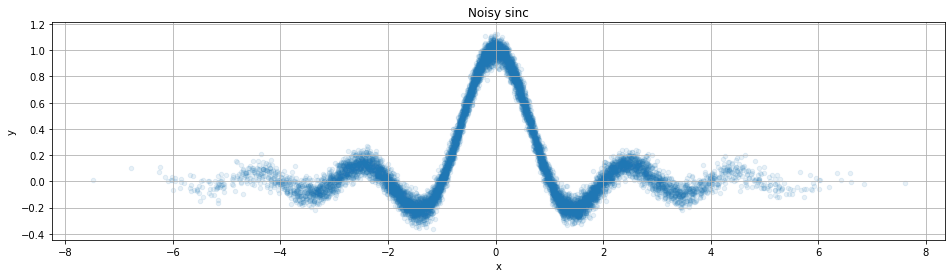

In [2]:
# parameters
n_data = 10000 # number of data
noise_std = 0.05 # noise standard deviation

# generate noisy sinc data
np.random.seed(seed=0)
X = np.random.normal(0,2,n_data).reshape(-1,1) # reshape makes a 2D array
noise = np.random.normal(0,noise_std,n_data)
y = np.sinc(X[:,0]) + noise # 1D array of size (n_data,)

# scatter plot of the data
plt.figure(figsize=(16,4))
plt.scatter(X[:,0],y,s=20,alpha=0.1)
plt.title('Noisy sinc')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

We will use a scikit-learn "Pipeline" to glue together the different processing steps of the method.  
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [13]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LinearRegression
from sklearn import pipeline

# parameters
n_components = 50 # size of the subset
gamma = 1 # kernel parameter

# define the feature map
feature_map_nystroem = Nystroem(gamma=gamma, n_components=n_components, random_state=0)

from sklearn.pipeline import Pipeline



# complete the code: 
# split the full kernel ridge regression into approximate feature map + linear regression
nystroem_approx_krr = Pipeline([('feature_map',feature_map_nystroem),('ridge',LinearRegression())])

### Train and test

In [14]:
# train the pipeline regressor
nystroem_approx_krr.fit(X,y)

# analyze both parts of the pipeline
print(nystroem_approx_krr.named_steps['feature_map'])
print(nystroem_approx_krr.named_steps['ridge'])

# Test the regressor
X_test = np.linspace(-8,8,1000).reshape(-1,1)
y_pred = nystroem_approx_krr.predict(X_test)

Nystroem(coef0=None, degree=None, gamma=1, kernel='rbf', kernel_params=None,
         n_components=50, random_state=0)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


### Plot the results

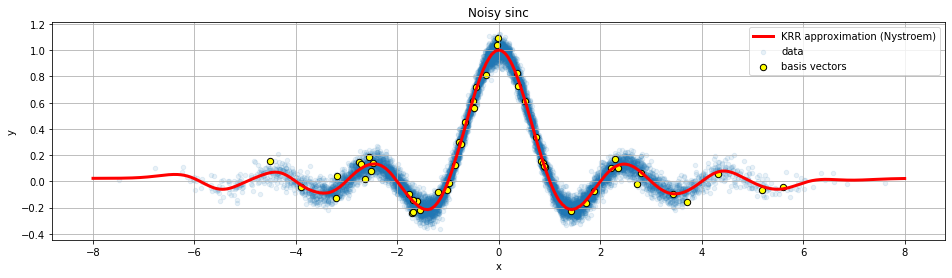

In [15]:
# indices of training subset used to construct the mapping
idx = nystroem_approx_krr.named_steps['feature_map'].component_indices_[:n_components]

# plot the results
plt.figure(figsize=(16,4))
plt.scatter(X[:,0],y,s=20,alpha=0.1,label='data')
plt.plot(X_test[:,0],y_pred,linewidth=3,color='red',label='KRR approximation (Nystroem)')
plt.scatter(X[idx,0],y[idx],s=40,color='yellow',alpha=1,edgecolor='black',label='basis vectors')
plt.title('Noisy sinc')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## 1.2 Random Fourier Features

The Random Fourier Features method approximates the feature map of an RBF kernel by Monte Carlo approximation of its Fourier transform.

We look for a finite dimensional mapping $\Psi$ such that:
$$\kappa({\bf x},{\bf y}) \approx \langle \Psi({\bf x}), \Psi({\bf y})\rangle$$

In the case of the Gaussian kernel, *Bochner’s theorem* shows that a mapping that satisfies this condition on average is

$$\Psi({\bf x}) = \sqrt{2} \cos(\omega^\top {\bf x} + b)$$

where b is drawn uniformly from $[0, 2\pi]$ and $\omega$ is drawn randomly from $\mathcal{N}(0, I_d/\sigma^2)$, where d is the input space dimension. In practice, we will sample $n$ values from the mapping and average out the resulting mapping.

This method is implemented in scikit-learn's "RBFSampler": http://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html

In [16]:
from sklearn.kernel_approximation import RBFSampler

# parameters
n_components = 100 # dimension of approximation
gamma = 1 # kernel parameter

# define the feature map
feature_map_fourier = RBFSampler(gamma=gamma, n_components=n_components, random_state=0)

# split the full kernel ridge regression into approximate feature map + linear regression
fourier_approx_krr = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("ridge", LinearRegression())])

### Train and test

In [17]:
# complete the code: train the regressor
fourier_approx_krr.fit(X,y)

# analyze both parts of the pipeline
print(fourier_approx_krr.named_steps['feature_map'])
print(fourier_approx_krr.named_steps['ridge'])

# Test the regressor
X_test = np.linspace(-6,6,1000).reshape(-1,1)
y_pred = fourier_approx_krr.predict(X_test)

RBFSampler(gamma=1, n_components=100, random_state=0)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


### Plot the results

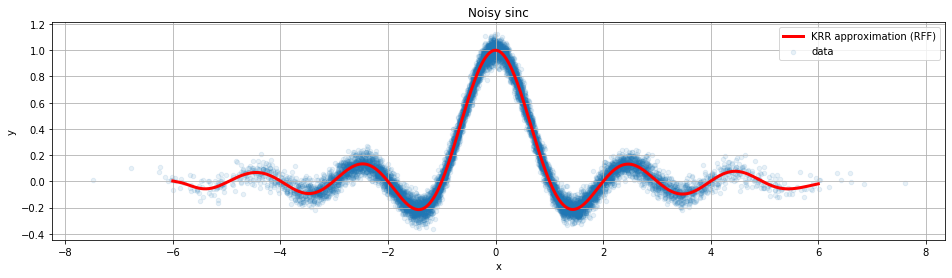

In [18]:
# plot the results
plt.figure(figsize=(16,4))
plt.scatter(X[:,0],y,s=20,alpha=0.1,label='data')
plt.plot(X_test[:,0],y_pred,linewidth=3,color='red',label='KRR approximation (RFF)')
plt.title('Noisy sinc')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

### Analysis

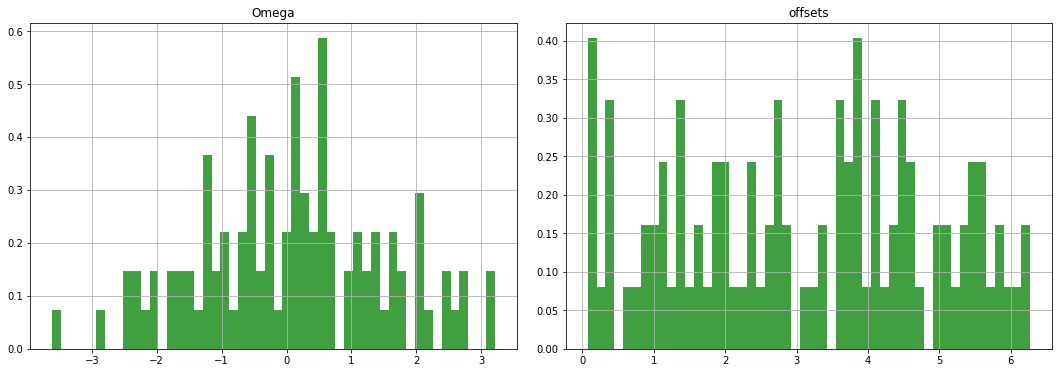

In [19]:
feature_map = fourier_approx_krr.named_steps['feature_map']

omega = feature_map.random_weights_.T # the random weights omega
offsets = feature_map.random_offset_.T # the random offsets b

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot the histograms
n, bins, patches = ax[0].hist(omega, 50, density=1, facecolor='g', alpha=0.75)
ax[0].grid(True)
ax[0].set_title("Omega")

# the histogram of the data
n, bins, patches = ax[1].hist(offsets, 50, density=1, facecolor='g', alpha=0.75)
ax[1].grid(True)
ax[1].set_title("offsets")

plt.show()

Try changing `n_components = 100` to a higher value and observe the results and internal coefficients `Omega` and `offsets`.

## Example: Nyström and RFF for classification

In the following example we will show how to use RBFSampler and the Nystroem method to approximate the feature map of an RBF kernel.
The problem will be classification of the UCI ML hand-written digits dataset using an SVM.
Three methods will be compared: a linear SVM in the original space, a linear SVM using the approximate mappings and a kernelized SVM.

First, let us load the data.

Size of the data: (1797, 64)
Size of the targets: (1797,)


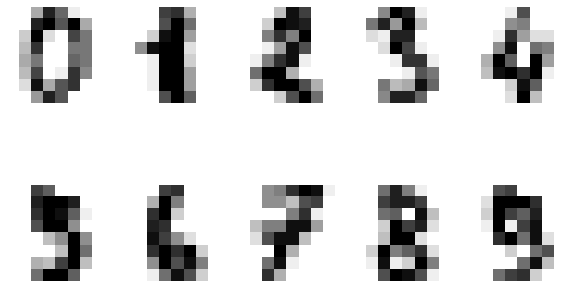

In [20]:
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from time import time

# The digits dataset
digits = datasets.load_digits(n_class=10)

print("Size of the data: {}".format(digits.data.shape))
print("Size of the targets: {}".format(digits.target.shape))

# Plot some digits
images_and_labels = list(zip(digits.images, digits.target))
plt.figure(figsize=(10,6))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

### Preprocess the data

In [24]:
# complete the code: normalize the data using a StandardScaler
scaler = StandardScaler()
scaler.fit(digits.data)
data = scaler.transform(digits.data)

data = StandardScaler().fit_transform(digits.data)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, 
                                                    test_size=0.33, random_state=0)

### Benchmark with linear SVM and full kernel SVM

We will use the "score" method of the classiier, which returns the mean accuracy.  
https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html

In [25]:
# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.02)
linear_svm = svm.LinearSVC(max_iter=2000, random_state=0)

# train and test with linear SVM
linear_svm_time = time()
linear_svm.fit(X_train, y_train)
linear_svm_score = linear_svm.score(X_test, y_test)
linear_svm_time = time() - linear_svm_time
print("Linear SVM training time: %.2f s. Score: %.2f"%(linear_svm_time,linear_svm_score))

# train and test with kernel SVM
kernel_svm_time = time()
kernel_svm.fit(X_train, y_train)
kernel_svm_score = kernel_svm.score(X_test, y_test)
kernel_svm_time = time() - kernel_svm_time
print("Kernel SVM training time: %.2f s. Score: %.2f"%(kernel_svm_time,kernel_svm_score))

C:\Users\Dave Mont\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear SVM training time: 0.50 s. Score: 0.94
Kernel SVM training time: 0.29 s. Score: 0.98


### Define the RFF and Nystroem classifiers

In [26]:
# create a pipeline from kernel approximation and linear svm
feature_map_fourier = RBFSampler(gamma=.02, random_state=1)
feature_map_nystroem = Nystroem(gamma=.02, random_state=1)

fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC())])

### Perform regression with different precisions of kernel approximations 

In [27]:
# define number of components / bases to test
sample_sizes = 50 * np.arange(1, 10)

fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    
    # set parameters
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    
    # train and time
    start = time()
    nystroem_approx_svm.fit(X_train, y_train)
    nystroem_times.append(time() - start)

    # train and time
    start = time()
    fourier_approx_svm.fit(X_train, y_train)
    fourier_times.append(time() - start)

    # store scores
    fourier_scores.append(fourier_approx_svm.score(X_test, y_test))
    nystroem_scores.append(nystroem_approx_svm.score(X_test, y_test))

### Plot the results

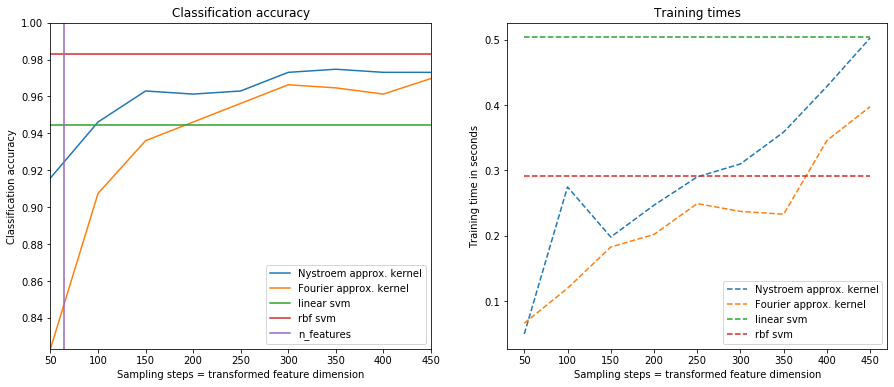

In [28]:
# plot the results:
plt.figure(figsize=(15, 6))
accuracy = plt.subplot(121)

# second y axis for timeings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_ylim(np.min(fourier_scores), 1)
accuracy.set_xlabel("Sampling steps = transformed feature dimension")
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')

plt.show();

### Visualization of the decision surface 

<Figure size 432x288 with 0 Axes>

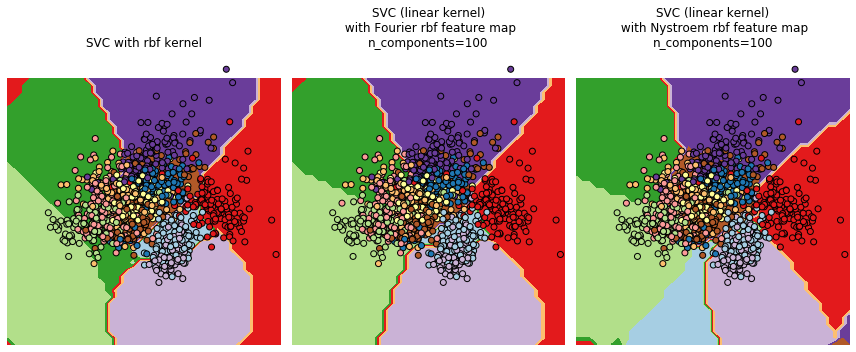

In [29]:
# visualize the decision surface, projected down to the first
# two principal components of the dataset
pca = PCA(n_components=8).fit(X_train)

X = pca.transform(X_train)

# Generate grid along first two principal components
multiples = np.arange(-10, 10, 0.5)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])

# title for the plots
titles = ['SVC with rbf kernel',
          'SVC (linear kernel)\n with Fourier rbf feature map\n'
          'n_components=100',
          'SVC (linear kernel)\n with Nystroem rbf feature map\n'
          'n_components=100']

plt.tight_layout()
plt.figure(figsize=(12, 5))

# predict and plot
for i, clf in enumerate((kernel_svm, nystroem_approx_svm,
                         fourier_approx_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y_train, cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))

    plt.title(titles[i])

plt.tight_layout()
plt.show();

### Note: SGDClassifier

When the data sets are still too large for batch training we can replace linear learners like Perceptron, Logistic Regression and SVM by `SGDClassifier` which implements stochastic-gradient-descent versions of these batch algorithms.

In [30]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

## Example: Nyström and RFF for regression

We will now compare both methods for the kernel ridge regression task on the KIN40K data set.

### KIN40K data set

- Forward kinematics of an 8-link all-revolute robot arm.
- 40000 examples, each consisting of an 8-dimensional input vector and a scalar output.
- KIN40K was generated with maximum nonlinearity and little noise.

![PUMA 560](https://i.imgur.com/qCN3Jk8.jpg)

### Data loading and preprocessing

In [33]:
from scipy.io import loadmat

kin40k = loadmat('kin40k.mat')

X = kin40k['X']
y = kin40k['y']

print('Data shape:\nX: %s\ny: %s\n'%(X.shape,y.shape))

# apply scaling with coefficients learned by Gaussian processes
loghyper = loadmat('kin40k_loghyper.mat')

# convert log values to normal range
scalers = np.exp(loghyper['loghyper'][0:8]).ravel()

# divide features by scaling coefficients
X /= scalers

Data shape:
X: (40000, 8)
y: (40000, 1)



### Data explorations

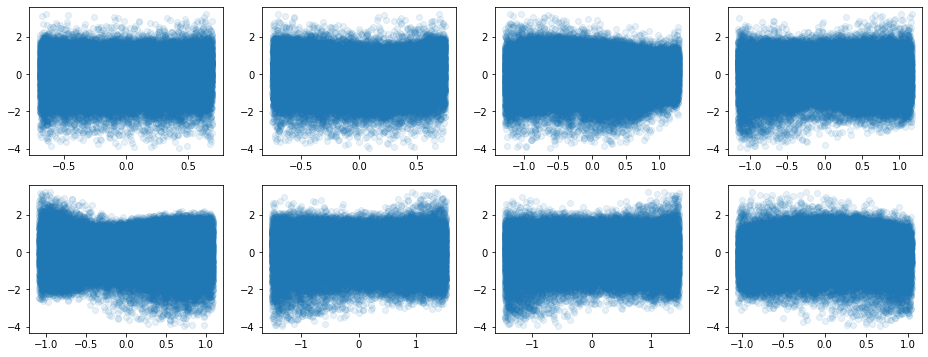

In [34]:
# EDA: 1D inputs vs output

plt.figure(figsize=(16,6))

for i in np.arange(X.shape[1]):
    plt.subplot(2,4,i+1)
    plt.scatter(X[:,i],y,alpha=0.1)
    
plt.show();

10.842420101165771


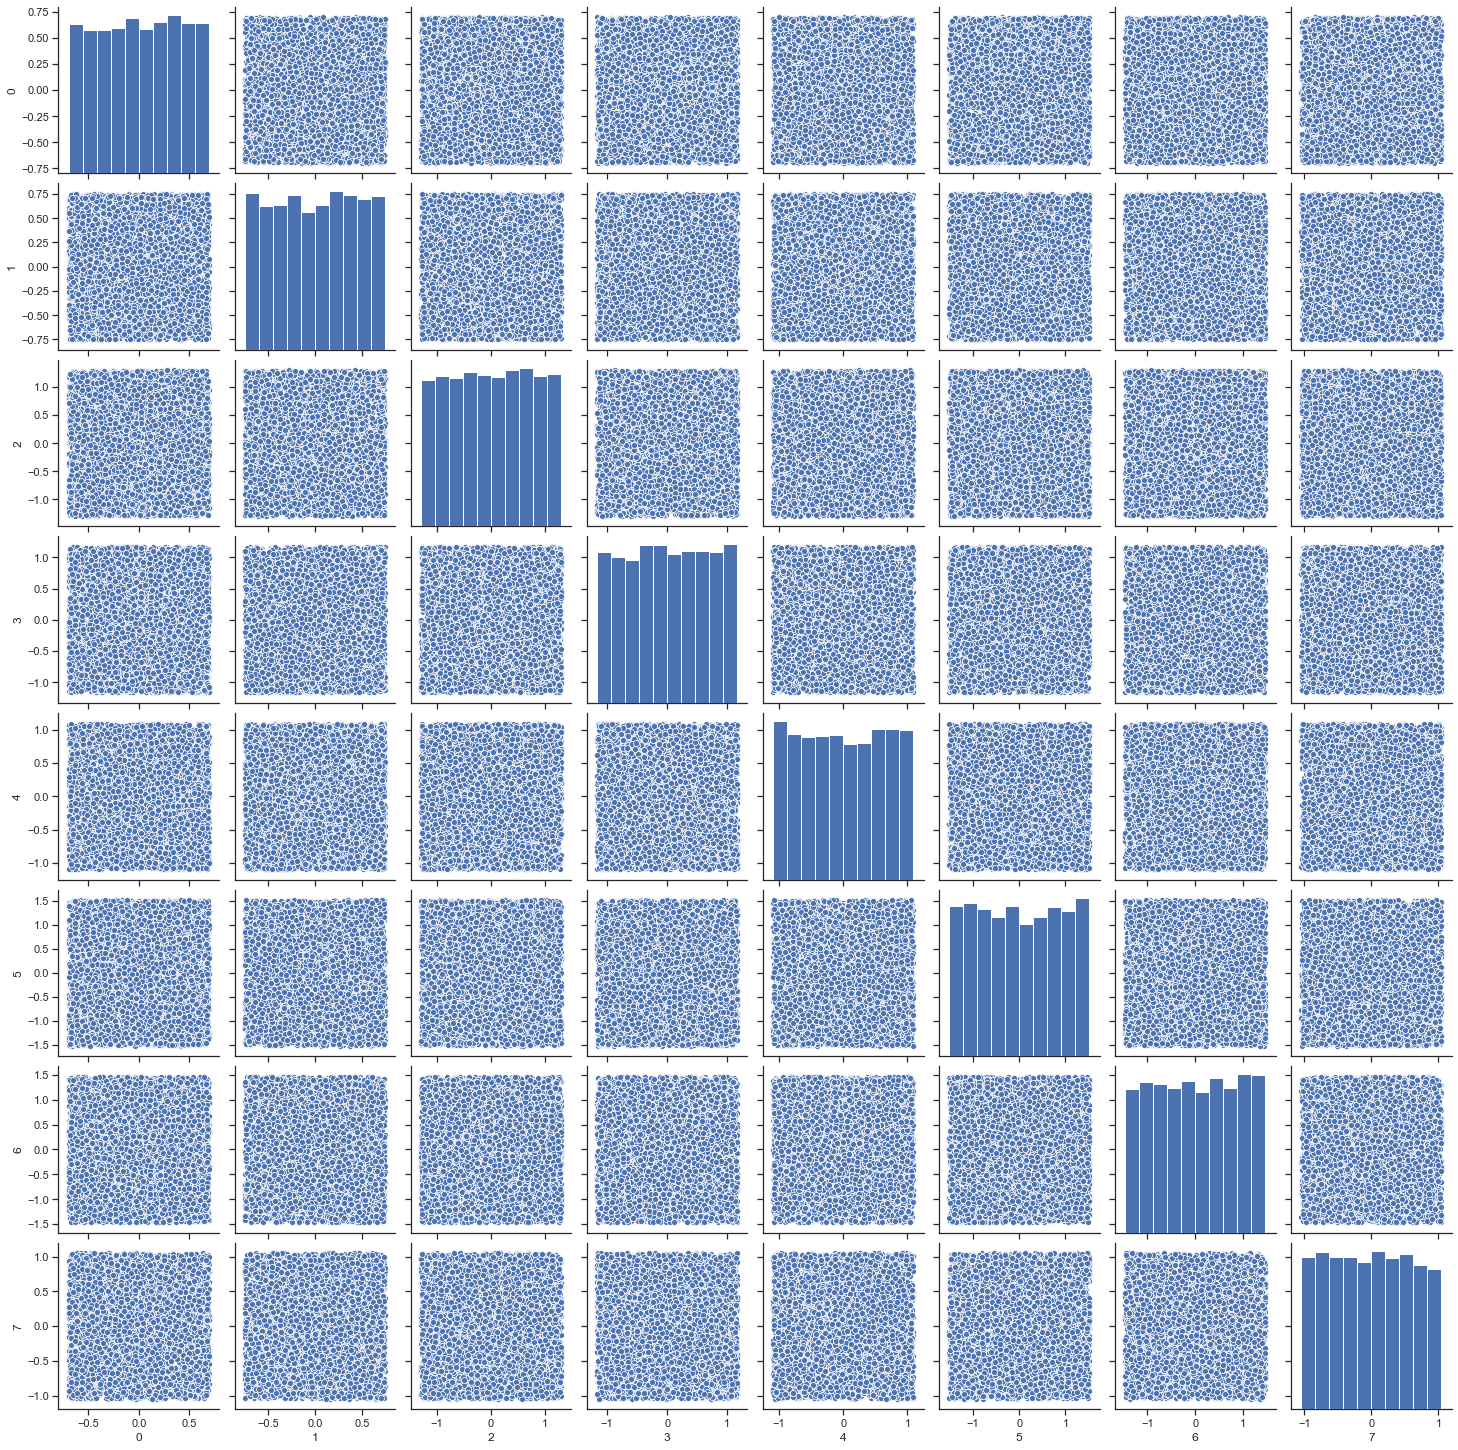

In [35]:
# pair plots

import seaborn as sns; sns.set(style="ticks", color_codes=True)

start = time()
df = pd.DataFrame(data=X[:5000,:])
g = sns.pairplot(df)
my_time = time() - start

print(my_time)

No structure is apparent.  
The KIN40K data set represents a difficult nonlinear regression problem.  
Let us train the predictors on the data set.

In [36]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.75, random_state=42)
    
print('Training data shape:\nX_train: %s\ny_train: %s\n'%(X_train.shape,y_train.shape))
print('Test data shape:\nX_test: %s\ny_test: %s'%(X_test.shape,y_test.shape))

Training data shape:
X_train: (10000, 8)
y_train: (10000, 1)

Test data shape:
X_test: (30000, 8)
y_test: (30000, 1)


### Standard ML techniques

In [37]:
# Try some standard regression methods

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)

# K-nearest neighbor regression
neigh= KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred_neigh = neigh.predict(X_test)

# calculate mean square error
mse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg)
mse_neigh = mean_squared_error(y_test, y_pred_neigh)

# print MSE values in standard scale and dB scale
print('MSE for Linear Regression: %.4f'%mse_lin_reg)
print('MSE for K-Nearest Neighbors: %.4f\n'%mse_neigh)
print('MSE (dB) for Linear Regression: %.4f'%(10*np.log10(mse_lin_reg)))
print('MSE (dB) for K-Nearest Neighbors: %.4f'%(10*np.log10(mse_neigh)))

MSE for Linear Regression: 0.9930
MSE for K-Nearest Neighbors: 0.1864

MSE (dB) for Linear Regression: -0.0304
MSE (dB) for K-Nearest Neighbors: -7.2944


## Exercise: Kernel Ridge Regression with Nyström and RFF transforms

Apply approximate kernel ridge regression to the KIN40K data.
Compare the results of the Nyström and RFF approximations.

A good starting value for the $\gamma$ parameter of the RBF kernel is $\gamma=1/2$. Find a fitting value for the parameter "n_components".

In [40]:

# TO DO: change the following lines to properly define the regressors
dummy = LinearRegression()

feature_map_fourier = RBFSampler(gamma=.02, random_state=1)
feature_map_nystroem = Nystroem(gamma=.02, random_state=1)

fourier_approx_krr = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", dummy)])

nystroem_approx_krr = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", dummy)])

# The next lines should not be changed:

# train the regressors
nystroem_approx_krr.fit(X_train,y_train)
fourier_approx_krr.fit(X_train,y_train)

# test the regressors
y_pred_nystroem = nystroem_approx_krr.predict(X_test)
y_pred_fourier = fourier_approx_krr.predict(X_test)

# calculate mean square error
mse_nystroem = mean_squared_error(y_test, y_pred_nystroem)
mse_fourier = mean_squared_error(y_test, y_pred_fourier)

# print MSE values in standard scale and dB scale
print('MSE for Nyström: %.4f'%mse_nystroem)
print('MSE for RFF: %.4f\n'%mse_fourier)
print('MSE (dB) for Nyström: %.4f'%(10*np.log10(mse_nystroem)))
print('MSE (dB) for RFF: %.4f'%(10*np.log10(mse_fourier)))

MSE for Nyström: 2268.1224
MSE for RFF: 0.4617

MSE (dB) for Nyström: 33.5567
MSE (dB) for RFF: -3.3564


# Part 2. Online and adaptive metods

## 2.1 Introduction: Perceptron

As an introductory example we will review the perceptron algorithm, which is based on a simple online learning rule.
This is a classification method, and we will apply it on the Iris data set.

In [41]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

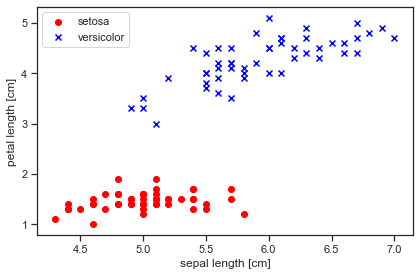

In [42]:
# select setosa and versicolor
y = y[0:100]
y = np.where(y == 0, -1, 1)

# extract sepal length and petal length
X = X[0:100, [0, 2]]

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [43]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """Fit all training data"""
        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                errori = self.fit_single(xi,target)
                errors += errori
            self.errors_.append(errors)
        return self
    
    def init_attr(self, input_dim):
        """Initialize attributes."""
        self.w_ = np.zeros(1 + input_dim)
        
    
    def fit_single(self,x,y):
        """Fit a single training datum"""
        update = self.eta * (y - self.predict(x))
        self.w_[1:] += update * x
        self.w_[0] += update
        
        error = int(update != 0.0)
        
        return error
        
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

Train the perceptron over 10 epochs on all training data:

Misclassified samples: 0


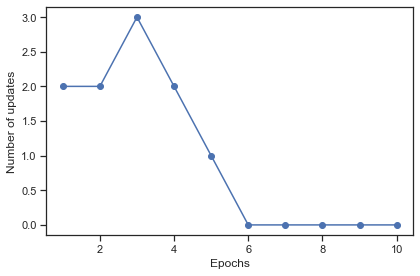

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0)

ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

# test on training data
y_pred = ppn.predict(X)

# training error
print('Misclassified samples: %d' % (y != y_pred).sum())

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

plt.tight_layout()
plt.show()

Let us analyze the errors committed in each individual iteration:

(10, 2)


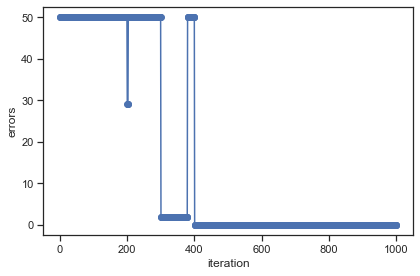

In [45]:
n_iter = 10
ppn = Perceptron(eta=0.1, n_iter=n_iter)
ppn.init_attr(input_dim=X.shape[1])

errors_all = []

print(X_test.shape)

for _ in range(n_iter):
    for xi, target in zip(X, y):
        # run fit_single() instead of fit()
        ppn.fit_single(xi,target)
        
        y_pred = ppn.predict(X)
        errors = (y != y_pred).sum()
        
        errors_all.append(errors)
    
plt.figure()
plt.plot(range(1, n_iter*X.shape[0] + 1), errors_all, marker='o')
plt.xlabel('iteration')
plt.ylabel('errors')

plt.tight_layout()
plt.show()

## 2.2 Kernel Least-Mean Squares algorithm

We now build the KLMS algorithm using the structure of the perceptron algorithm.
Take into account that KLMS is a regression algorithm.

In [46]:
from sklearn.gaussian_process.kernels import RBF

class KLMS(object):
    """Kernel Least Mean Squares algorithm"""
    def __init__(self, mu=0.5, kernel=RBF()):
        self.mu = mu
        self.kernel = kernel
        
    def init_attr(self, input_dim):
        """Initialize attributes"""
        self.alpha_ = np.empty((0,), float)
        self.dict = np.empty((0,input_dim), float)
    
    def fit_single(self,x,y):
        """Train for one datum"""
        if not hasattr(self, 'dict'):
            # initialize
            self.init_attr(x.shape[0])

        err = y - self.predict(x)
        update = self.mu * err
        self.alpha_ = np.hstack((self.alpha_,update))
        self.dict = np.vstack((self.dict,x))

    def predict(self, X):
        """Predict outputs"""
        K = self.kernel.__call__(X,self.dict)
        return np.dot(K,self.alpha_)

Let us test KLMS on the noisy sinc data:

In [47]:
# generate noisy sinc data
n_data = 500
np.random.seed(seed=0)
X = np.random.normal(0,2,n_data).reshape(-1,1)
noise = np.random.normal(0,0.05,n_data)
y = np.sinc(X[:,0]) + noise

Elapsed time: 1.80 s.


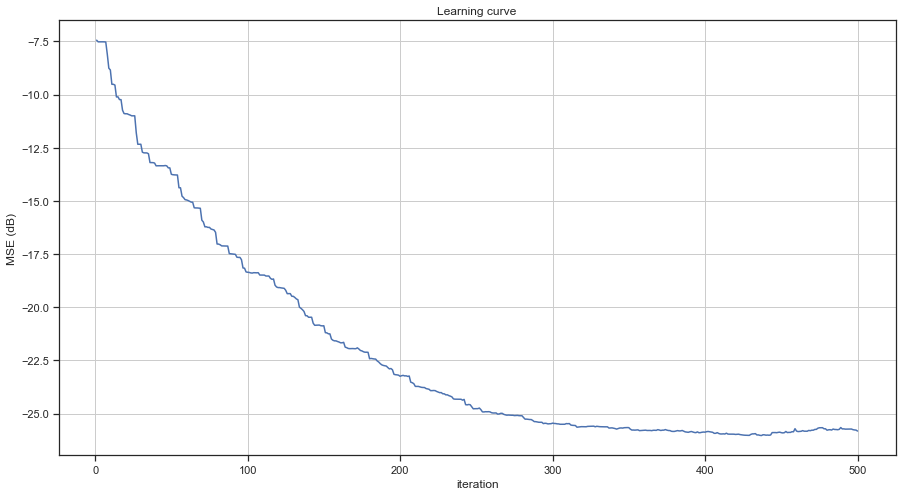

In [48]:
klms = KLMS(mu=0.1, kernel=RBF(length_scale=.5))

mse_all = []

start = time()
for xi, target in zip(X, y):
    klms.fit_single(xi,target)

    y_pred = klms.predict(X)
    mse = mean_squared_error(y, y_pred)

    mse_all.append(mse)
klms_time = time() - start

print('Elapsed time: %.2f s.'%klms_time)

plt.figure(figsize=(15,8))
plt.plot(range(1, X.shape[0] + 1), 10*np.log10(mse_all))
plt.xlabel('iteration')
plt.ylabel('MSE (dB)')
plt.title('Learning curve')
plt.grid(True)
plt.show()

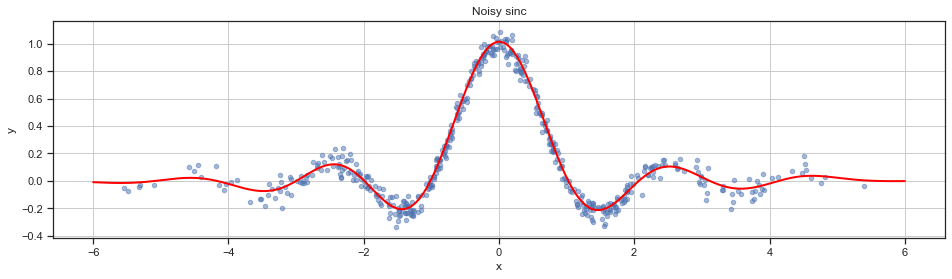

In [49]:
# Test the regressor
X_test = np.linspace(-6,6,1000).reshape(-1,1)
y_pred = klms.predict(X_test)

# plot the results
plt.figure(figsize=(16,4))
plt.scatter(X[:,0],y,s=20,alpha=0.5)
plt.plot(X_test[:,0],y_pred,linewidth=2,color='red')
plt.title('Noisy sinc')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

## 2.3 Coherence Criterion: Kernel Normalized Least Mean Squares

In order to reduce the memory size, we will now implement the KNLMS algorithm, which slows down the dictionary growth by using a coherence-criterion based mechanism.

In [50]:
class KNLMS(object):
    """Kernel Normalised Least Mean Squares algorithm"""
    def __init__(self, eta=0.5, mu0=0.8, eps=1E-2, kernel=RBF()):
        self.eta = eta # step size
        self.mu0 = mu0 # coherence threshold
        self.eps = eps # regularization
        self.kernel = kernel
        
    def init_attr(self, input_dim):
        """Initialize attributes"""
        self.alpha_ = np.empty((0,), float)
        self.dict = np.empty((0,input_dim), float)
    
    def fit_single(self,x,y):
        """Train for one datum"""
        if not hasattr(self, 'dict'):
            # initialize
            self.init_attr(x.shape[0])
            
            self.dict = np.vstack((self.dict,x))
            self.alpha_ = np.hstack((self.alpha_,0))        
        else:
            k = self.kernel.__call__(x,self.dict)
            if np.amax(k) < self.mu0:
                self.dict = np.vstack((self.dict,x))
                self.alpha_ = np.hstack((self.alpha_,0))
        
        k = np.squeeze(np.asarray(self.kernel.__call__(x,self.dict)))
        err = y - self.predict(x)
        
        # update alpha
        self.alpha_ = self.alpha_ + self.eta / (self.eps + np.dot(k,k)) * err * k;
        self.alpha_ = self.alpha_.ravel()

    def predict(self, X):
        """Predict outputs"""
        K = self.kernel.__call__(X,self.dict)
        return np.dot(K,self.alpha_)

Elapsed time: 0.43 s.
Final dictionary size: 32 bases.


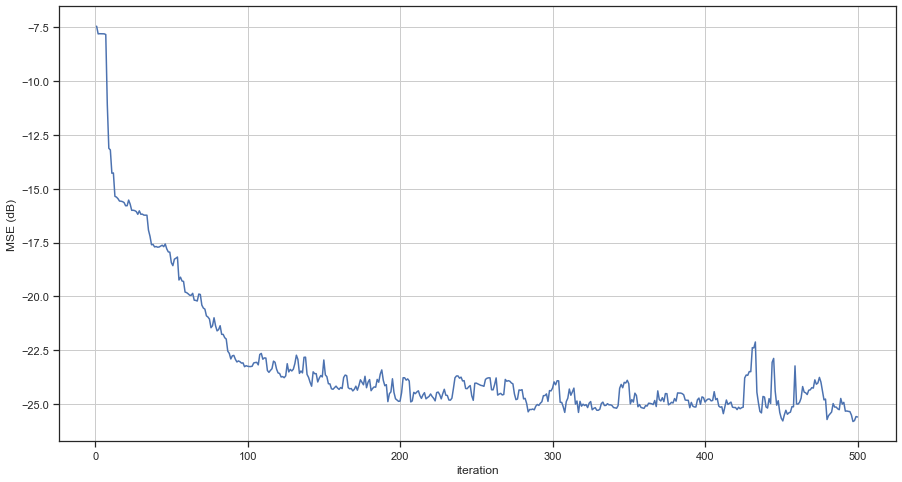

In [51]:
knlms = KNLMS(eta=0.5, mu0=0.9, kernel=RBF(length_scale=.5))

mse_all = []

start = time()
for xi, target in zip(X, y):
    knlms.fit_single(xi,target)

    y_pred = knlms.predict(X)
    mse = mean_squared_error(y, y_pred)

    mse_all.append(mse)
knlms_time = time() - start

print('Elapsed time: %.2f s.'%knlms_time)

print('Final dictionary size: %d bases.'%knlms.dict.shape[0])

plt.figure(figsize=(15,8))
plt.plot(range(1, X.shape[0] + 1), 10*np.log10(mse_all))
plt.xlabel('iteration')
plt.ylabel('MSE (dB)')
plt.grid(True)
plt.show()

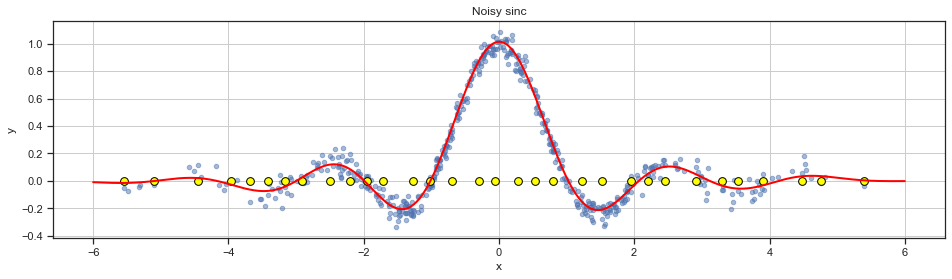

In [52]:
# Test the regressor
X_test = np.linspace(-6,6,1000).reshape(-1,1)
y_pred = klms.predict(X_test)

# plot the results
plt.figure(figsize=(16,4))
plt.scatter(X[:,0],y,s=20,alpha=0.5)
plt.plot(X_test[:,0],y_pred,linewidth=2,color='red')
plt.scatter(knlms.dict,np.zeros(knlms.dict.shape[0],),s=60,color='yellow',edgecolor='black')
plt.title('Noisy sinc')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

Example: Nonlinear channel equalization
---

Reference: https://github.com/steven2358/kafbox/blob/master/demo/literature/liu2010kernel/fig2_12.m

Data shape:
x: (4996, 1)
y: (4996, 1)



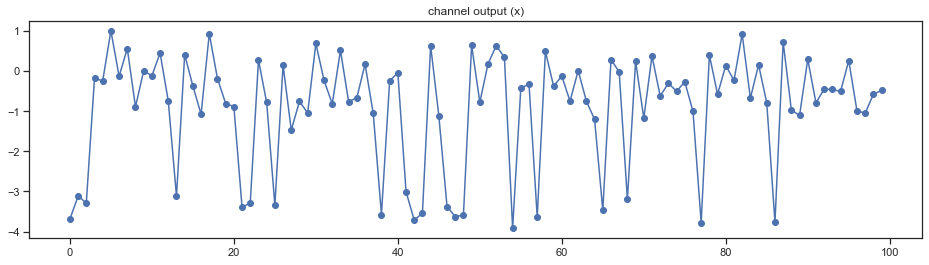

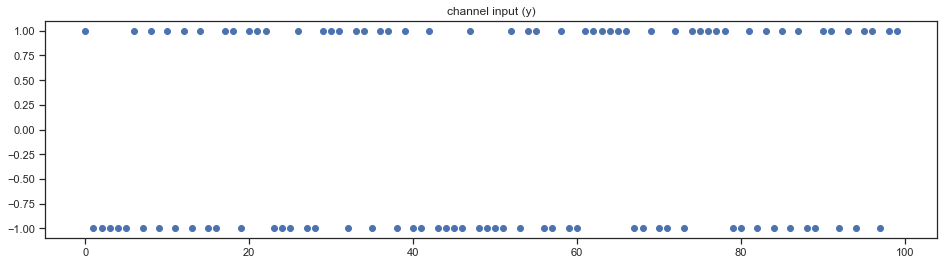

In [53]:
channel_data = loadmat('nonlinear_channel_eq.mat')

x = channel_data['x']
y = channel_data['y']

n_samples = len(x)

print('Data shape:\nx: %s\ny: %s\n'%(x.shape,y.shape))

plt.figure(figsize=(16,4))
plt.plot(x[0:100],'-o')
plt.title('channel output (x)')
plt.show()

plt.figure(figsize=(16,4))
plt.plot(y[0:100],'o')
plt.title('channel input (y)')
plt.show()

In [54]:
# add embedding to input

embedding = 5

# time embedding
X = np.zeros((n_samples,embedding))
for i in np.arange(0,embedding):
    X[i:,i] = x[0:n_samples-i].ravel()

Training KNLMS...
Elapsed time: 1.68 s.
Final dictionary size: 206 bases.

Training KLMS...
Elapsed time: 2.68 s.
Final dictionary size: 2000 bases.



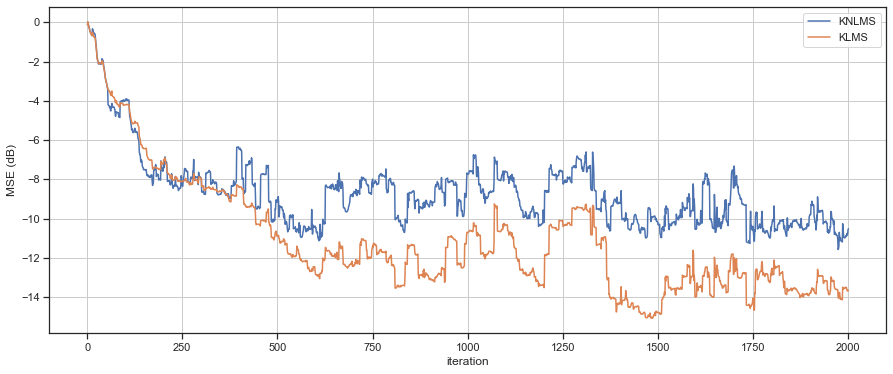

(2000, 5)
(50, 5)


In [55]:
# define train and test size
n_tr = 2000
n_te = 50

X_train = X[0:n_tr]
y_train = y[0:n_tr]

X_test = X[n_tr:n_tr+n_te]
y_test = y[n_tr:n_tr+n_te]

# define the predictors

knlms = KNLMS(eta=0.5, mu0=0.5, kernel=RBF(length_scale=1))
klms = KLMS(mu=0.5, kernel=RBF(length_scale=1))

predictors = [knlms, klms]

plt.figure(figsize=(15,6))

for predictor in predictors:

    mse_all = []

    pname = predictor.__class__.__name__
    print('Training %s...'%pname)

    start = time()
    for xi, yi in zip(X_train, y_train):

        # train on new datum
        predictor.fit_single(xi,yi)

        # predict output
        y_pred = predictor.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_all.append(mse)    

    predictor_time = time() - start

    print('Elapsed time: %.2f s.'%predictor_time)

    print('Final dictionary size: %d bases.\n'%predictor.dict.shape[0])
    
    plt.plot(range(1, len(mse_all) + 1), 10*np.log10(mse_all), label=pname)

plt.xlabel('iteration')
plt.ylabel('MSE (dB)')
plt.legend()
plt.grid(True)
plt.show()

print(X_train.shape)
print(X_test.shape)

Exercise: Fixed-Budget Kernel Least Mean Squares
---

The dictionary size can be limited by curbing its growth, which is what the coherence criterion is used for.
An alternative way of limiting the dictionary size is by *removing* bases that are less relevant.
In practice, we will start removing bases from the dictionary (and their corresponding coefficients from alpha) once the dictionary reaches a predefined size.

In this exercise you will implement a modified KLMS algorithm that includes dictionary pruning:
1. Modify the KLMS algorithm: In `__init__()`, add a parameter `max_bases` that indicates the maximum size of the dictionary.
2. In the `fit()` method, add a check to see if the dictionary size has reached the maximum. If this is the case, remove the dictionary element that corresponds to the coefficient of alpha with the lowest absolute value. Prune the dictionary element and the corresponding alpha coefficient.
3. Obtain the learning curve of this algorithm to KLMS and KNLMS. 
4. Describe the results.

In [70]:
# 1. and 2. Implement the modified KLMS algorithm

class SFBKLMS(object):
    """Simple Fixed Budget Kernel Least Mean Squares algorithm"""
    def __init__(self, mu=0.5, max_bases = 500, kernel=RBF()):
        self.max_bases = max_bases
        self.mu = mu
        self.kernel = kernel
        
    def init_attr(self, input_dim):
        """Initialize attributes"""
        self.alpha_ = np.empty((0,), float)
        self.dict = np.empty((0,input_dim), float)
    
    def fit_single(self,x,y):
        """Train for one datum"""
        if not hasattr(self, 'dict'):
            # initialize
            self.init_attr(x.shape[0])
        
        if self.dict.shape[0] >= self.max_bases:
            idx = np.absolute(self.alpha_).argmin()
            self.alpha_ = np.delete(self.alpha_,idx)
            self.dict = np.delete(self.dict,idx,0)            
        
        err = y - self.predict(x)
        update = self.mu * err
        self.alpha_ = np.hstack((self.alpha_,update))
        self.dict = np.vstack((self.dict,x))            

    def predict(self, X):
        """Predict outputs"""
        K = self.kernel.__call__(X,self.dict)
        return np.dot(K,self.alpha_)

Training KNLMS...
Elapsed time: 1.66 s.
Final dictionary size: 206 bases.

Training KLMS...
Elapsed time: 2.83 s.
Final dictionary size: 2000 bases.

Training SFBKLMS...
Elapsed time: 2.09 s.
Final dictionary size: 500 bases.



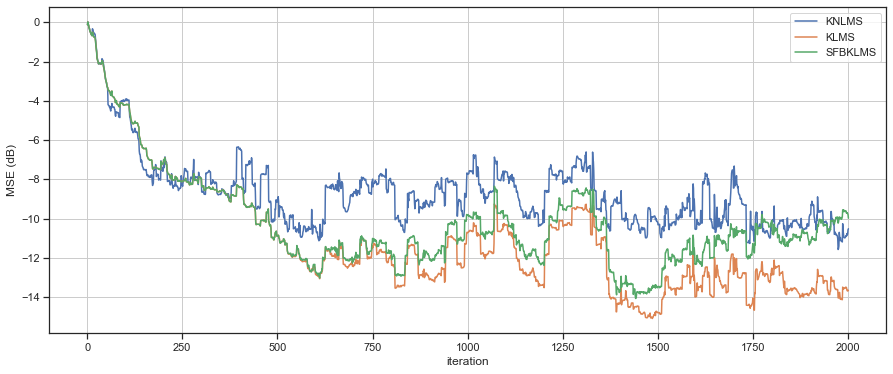

In [71]:
# 3. If required, modify the  algorithm parameters. Obtain the learning curves.

# define the predictors

knlms = KNLMS(eta=0.5, mu0=0.5, kernel=RBF(length_scale=1))
klms = KLMS(mu=0.5, kernel=RBF(length_scale=1))

# add this parameter to the method
max_bases = 500
sfbklms = SFBKLMS(mu=0.5, kernel=RBF(length_scale=1))

predictors = [knlms, klms, sfbklms]
#predictors = [sfbklms]

plt.figure(figsize=(15,6))

for predictor in predictors:

    mse_all = []

    pname = predictor.__class__.__name__
    print('Training %s...'%pname)

    start = time()
    for xi, yi in zip(X_train, y_train):

        # train on new datum
        predictor.fit_single(xi,yi)

        # predict output
        y_pred = predictor.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_all.append(mse)    

    predictor_time = time() - start

    print('Elapsed time: %.2f s.'%predictor_time)

    print('Final dictionary size: %d bases.\n'%predictor.dict.shape[0])
    
    plt.plot(range(1, len(mse_all) + 1), 10*np.log10(mse_all), label=pname)

plt.xlabel('iteration')
plt.ylabel('MSE (dB)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 4. Describe the result of the modified KLMS algorithm:
# Did you find a parameter setting that produces good results?
# Do the results hold if you raise n_tr?
# Is this algorithm an improvement of KLMS?

### Sources

- [Python Machine Learning by Sebastian Raschka](https://github.com/rasbt/python-machine-learning-bookk). MIT License.
- [scikit-learn Examples](http://scikit-learn.org/stable/auto_examples/). BSD License.
